## Final Project
By: Lisa Chille, Bobby Gonzalez, Bahlakoana Mabetha

In [1]:
import numpy as np
from scipy.optimize import fmin_l_bfgs_b as lbfgs
#from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qutip import *
%matplotlib notebook
from IPython.display import Image

from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_sparse_operator
from openfermion.utils import get_ground_state

## Reference
https://arxiv.org/pdf/1612.02806.pdf - mainly based on this paper.

## Functions 

### Unitary gate
The unitary gate architecture, $U_p$, it takes in angles as parameters.

In [2]:
def unitary_p (p_values):
    N = 4
    qc = QubitCircuit(N) # Initialize quantum circuit with 4 qubits

    # Add Gates
    qc.add_gate("PHASEGATE", 0, None, p_values[0]) 
    qc.add_gate("PHASEGATE", 1, None, p_values[1]) 
    qc.add_gate("PHASEGATE", 2, None, p_values[2]) 
    qc.add_gate("PHASEGATE", 3, None, p_values[3]) 
    qc.add_gate("CPHASE", 1, 0, p_values[4]) 
    qc.add_gate("CPHASE", 2, 0, p_values[5]) 
    qc.add_gate("CPHASE", 3, 0, p_values[6]) 
    qc.add_gate("CPHASE", 0, 1, p_values[7]) 
    qc.add_gate("CPHASE", 2, 1, p_values[8]) 
    qc.add_gate("CPHASE", 3, 1, p_values[9]) 
    qc.add_gate("CPHASE", 0, 2, p_values[10]) 
    qc.add_gate("CPHASE", 1, 2, p_values[11]) 
    qc.add_gate("CPHASE", 3, 2, p_values[12]) 
    qc.add_gate("CPHASE", 0, 3, p_values[13]) 
    qc.add_gate("CPHASE", 1, 3, p_values[14]) 
    qc.add_gate("CPHASE", 2, 3, p_values[15]) 
    qc.add_gate("PHASEGATE", 0, None, p_values[16]) 
    qc.add_gate("PHASEGATE", 1, None, p_values[17]) 
    qc.add_gate("PHASEGATE", 2, None, p_values[18]) 
    qc.add_gate("PHASEGATE", 3, None, p_values[19]) 

    # Find product of gates
    U_p = gate_sequence_product(qc.propagators())

    return U_p

### Fidelity
The `fidelity` function, $F(|\psi_i \rangle, \rho_i^{out}) = \langle \psi_i|\rho_i^{out}|\psi_i \rangle$. In this case, the variables to $F$ are $Tr_A[U_{}]$. Where $Tr_A$ is interpreted to be the partial trace over the qubits that we keep after encoding. 

In [3]:
def fidelity(unitary_p, psis, reference):
    expects = 0
    for i in range(len(psis)):
        psi=psis[i]
        psi_tens = Qobj(np.dot(psi.data.todense(),psi.data.todense().T))
        unitary_mapping=Qobj(np.dot(unitary_p.data.todense(),np.dot(unitary_p.data.todense(),psi_tens.data.todense())))
        unitary_mapping.dims = [[[2,2],[2,2]],[[2,2],[2,2]]]
        partial = unitary_mapping.ptrace([2,3])
        partial.dims= [[4], [4]]
        expects += expect(partial,reference)
    return expects

### Cost function
The `cost` function, $C_2(\vec{p})$. It takes in the fidelity and rotation angles and sums over the product of the two.

In [4]:
'''
def cost(params, *args):
    cost = 0
    unitary = unitary_p(params)
    for p in params:
        cost += p*fidelity(unitary,args[0],args[1])
    return 1 - cost

'''    
def cost(params, *args):
    cost = 0
    psis = args[0]
    reference = args[1]
    U_p = unitary_p(params)
    U_p.dims=[[16],[16]]
    for i in range(len(psis)):
        psi_in = psis[i]
        psi_up = np.dot(U_p, psi_in)
        psi_swap = swap_trashref(psi_up, reference, params)
        psi_out = np.dot(U_p.dag(), psi_swap)
        ampl = psi_in.trans()*psi_out
        prob = ampl.dag()*ampl
        prob = prob.data.toarray()
        cost += prob 
    return 1 - cost[0,0]

### Reference States
The get reference function. It generates the fuction that will be used in decoding stage to recreate the input states. It also used to calculate fidelity. In this case we are using the $|0\rangle$ as reference states. It takes in K, number of bits to be replaced, i, basis state used, length.

In [5]:
def get_reference(states, k):
    reference = states [k]
    reference = Qobj(reference[0:8])
    return reference

### Ground States of a H2 Molecule
The `get_inputs` function. The function returns the groundstate and energies of the $H_2$ molecule for different molecular raduis.

In [6]:
def get_inputs():
    states = []
    energies = []
    for i in np.arange(0.2,4.2,0.1):
        string = 'H2_sto-3g_singlet_'+str(i)+'.hdf5'
        molecule = MolecularData(filename = string)
        molecular_ham = molecule.get_molecular_hamiltonian()
        molecular_ham_sparse = get_sparse_operator(operator=molecular_ham, n_qubits=4)
        ground_energy, ground_state = get_ground_state(molecular_ham_sparse)
        energies.append(ground_energy)
        states.append(ground_state)
    return states, energies

### Swap
The `swap_trashref` function. This function swaps the trash states with the reference states, the resulting state is used to recreate the input states.

In [7]:
def swap_trashref(psis, references, params):
    unitary = unitary_p(params)
    unitary.dims=[[16],[16]]
    psi = unitary*psis
    psi = psi.data.toarray()
    references = references.data.toarray()
    k = len(references)
    psi_swap = np.concatenate((references, psi[k:len(psi),:]), axis = 0)
    psi_swap = Qobj(psi_swap)
    return psi_swap

### Optimisation
This `optimisation` function will apply the unitary as many times as necessary to in order to minimise epsilon where epsilon is determined by the cost function.

### Gradient Decent
Calculate the hypothesis h = X * theta
Calculate the loss = h - y and maybe the squared cost (loss^2)/2m
Calculate the gradient = X' * loss / m
Update the parameters theta = theta - alpha * gradient

https://stackoverflow.com/questions/17784587/gradient-descent-using-python-and-numpy?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

In [8]:
def gradientDescent(train, reference, p_values, alpha, m, numIterations):
    psis = train
    losses = []
    costs = []
    for i in range(0, numIterations):
        hypothesis = []
        gradient = 0
        cost = 0
        U_p = unitary_p(p_values)
        U_p.dims=[[16],[16]]
        for j in range (len(psis)):
            psi_in = psis[j]
            psi_up = np.dot(U_p, psi_in)
            psi_swap = swap_trashref(psi_up, reference, p_values)
            psi_out = np.dot(U_p.dag(), psi_swap)
            hypothesis.append(psi_out)
            
            ampl = psi_in.trans()*psi_out
            prob = ampl.dag()*ampl
            prob = prob.data.toarray()
            cost += prob
        hypothesis = np.asarray(hypothesis)
        #hypothesis = hypothesis.data.toarray()
        #train = train.data.toarray()
        train = np.asarray(train)
        loss = hypothesis - train
        # avg gradient per example
        for k in range (len(train)):
            gradient += train[k].trans()*loss[k]
        gradient = gradient[0][0][0] / m
        costs.append(cost)
        # update
        p_values = p_values - alpha * gradient
        p_values = p_values.real
    return p_values, costs

## Create input states

In [9]:
states, energies = get_inputs()
k = 0
reference = get_reference(states, k)

## Prepare States

In [10]:
for i in range(len(states)):
    states[i] = Qobj(states[i])

## Prepare Training data

In [11]:
test_ind = [1,3,5,7,10,14,18,22,28,36]
train = []
for i in range(len(test_ind)):
    train.append(states[test_ind[i]])

In [12]:
reference

Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[ -4.77792529e-17 -1.05277101e-19j]
 [  8.80942537e-17 +1.83797119e-16j]
 [ -2.49930333e-17 +4.90932310e-17j]
 [ -3.93979145e-02 +1.54782526e-02j]
 [ -2.87119123e-17 +2.87189513e-17j]
 [ -6.78035034e-18 -5.11226063e-17j]
 [  4.81743691e-17 +7.59067339e-17j]
 [  1.39996361e-16 -1.53833527e-16j]]

## Initial rotation angle
This assumes that the angles are independent, $P(\theta_i|\theta_j) = P(\theta_i)$. The initial angles are a random guess.

In [13]:
initial_values = np.random.random_sample(20)*2*np.pi

## Train the architecture 
This is used to determine the optimal angels for each rotation gate. Optimization is done using the lbfgs optimizing function.

In [14]:
#threeparam1 = lbfgs(cost, x0=initial_values, args=(train,
                                                   #reference),
                                                   #approx_grad=True)

In [15]:
threeparam1, costs = gradientDescent(train, reference, initial_values, 0.01, len(states), 1000)

## Compare initial values and optimized values

In [16]:
initial_values

array([ 2.70241768,  2.57503959,  4.01136425,  3.10737094,  0.08332656,
        3.78507115,  5.47977885,  2.99916006,  3.95196265,  5.09168421,
        1.24382112,  5.81866979,  0.55941062,  2.58223849,  4.25905621,
        1.2309486 ,  4.8957945 ,  0.76611861,  0.8470052 ,  2.5768277 ])

In [17]:
threeparam1[0]%(2*np.pi)

3.5431999917654728

In [18]:
threeparam1

array([ 3.54319999,  3.4158219 ,  4.85214656,  3.94815326,  0.92410887,
        4.62585347,  6.32056116,  3.83994237,  4.79274497,  5.93246653,
        2.08460344,  6.6594521 ,  1.40019294,  3.42302081,  5.09983853,
        2.07173091,  5.73657681,  1.60690093,  1.68778751,  3.41761001])

## Input the optimized values in the architecture

In [19]:
opt_p = threeparam1%(2*np.pi)
U_p = unitary_p(opt_p)
U_p.dims=[[16],[16]]
display(U_p)

Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[ 1.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.46905314+0.88316994j  0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.96722070+0.25393724j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          

## Compute encoding 

In [20]:
probs = []
for i in range(len(states)):
    psi_in = states[i]
    psi_up = np.dot(U_p, psi_in)
    psi_up = psi_up /(psi_up.norm())
    psi_swap = swap_trashref(psi_up, reference, opt_p)
    psi_swap = psi_swap /(psi_swap.norm())
    psi_out = np.dot(U_p.dag(), psi_swap)
    psi_out = psi_out/(psi_out.norm()) 
    ampl = psi_in.dag()*psi_out
    amp2 = psi_out.dag()*psi_in
    prob = ampl*amp2
    # prob = ampl.dag()*ampl
    prob = prob.data.toarray()
    probs.append(prob[0][0])

In [21]:
amp2 = psi_out.dag()*psi_in
prob = ampl*amp2

In [22]:
prob[0]

array([[ 0.55448815+0.j]])

In [23]:
prob = ampl.dag()*ampl

In [24]:
prob

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[ 0.55448815]]

## Plot the recreation probability

In [25]:
probs

[(0.99753404148171732+0j),
 (0.99555349391248338+0j),
 (0.98968898750860146+0j),
 (0.99204382212967901+0j),
 (0.99644546636783893+0j),
 (0.98884148782684833+0j),
 (0.97237479894063628+0j),
 (0.96470134981579503+0j),
 (0.98216944404675166+0j),
 (0.97338518577880617+0j),
 (0.94322263850233656+0j),
 (0.90121954300106011+0j),
 (0.92562039865829104+0j),
 (0.8423281132751691+0j),
 (0.8670536501192565+0j),
 (0.80274950138241408+0j),
 (0.81040883279545373+0j),
 (0.70017307850956134+0j),
 (0.68576499495134824+0j),
 (0.72018468861822704+0j),
 (0.68065497190393354+0j),
 (0.60191715136260293+0j),
 (0.5991079890119444+0j),
 (0.6380197136982535+0j),
 (0.57817190663104467+0j),
 (0.51738068860255904+0j),
 (0.49954077134522729+0j),
 (0.53617473191362153+0j),
 (0.59146449259480749+0j),
 (0.54692866250997751+0j),
 (0.47195896713613905+0j),
 (0.49560800953023443+0j),
 (0.54188408424060186+0j),
 (0.4560918250795794+0j),
 (0.47928643017200379+0j),
 (0.45365692333653573+0j),
 (0.55673395165402684+0j),
 (0.49

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5,0,'Molecular Bond Length (Angstrom)')

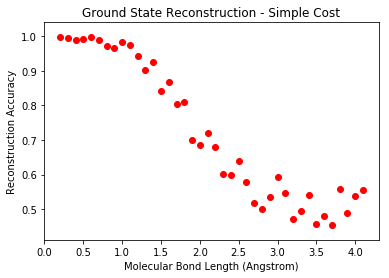

In [26]:
x = np.arange(0.2,4.2,0.1)
plt.scatter(x,probs, c = 'r')
plt.title('Ground State Reconstruction - Simple Cost')
plt.ylabel('Reconstruction Accuracy')
plt.xlabel('Molecular Bond Length (Angstrom)')

In [27]:
costs

[array([[ 6.88613022+0.j]]),
 array([[ 6.88615855+0.j]]),
 array([[ 6.88618724+0.j]]),
 array([[ 6.8862163+0.j]]),
 array([[ 6.88624572+0.j]]),
 array([[ 6.88627552+0.j]]),
 array([[ 6.88630569+0.j]]),
 array([[ 6.88633625+0.j]]),
 array([[ 6.88636719+0.j]]),
 array([[ 6.88639851+0.j]]),
 array([[ 6.88643023+0.j]]),
 array([[ 6.88646234+0.j]]),
 array([[ 6.88649486+0.j]]),
 array([[ 6.88652777+0.j]]),
 array([[ 6.8865611+0.j]]),
 array([[ 6.88659483+0.j]]),
 array([[ 6.88662898+0.j]]),
 array([[ 6.88666355+0.j]]),
 array([[ 6.88669855+0.j]]),
 array([[ 6.88673397+0.j]]),
 array([[ 6.88676982+0.j]]),
 array([[ 6.88680611+0.j]]),
 array([[ 6.88684285+0.j]]),
 array([[ 6.88688002+0.j]]),
 array([[ 6.88691765+0.j]]),
 array([[ 6.88695573+0.j]]),
 array([[ 6.88699427+0.j]]),
 array([[ 6.88703327+0.j]]),
 array([[ 6.88707274+0.j]]),
 array([[ 6.88711269+0.j]]),
 array([[ 6.8871531+0.j]]),
 array([[ 6.88719401+0.j]]),
 array([[ 6.88723539+0.j]]),
 array([[ 6.88727727+0.j]]),
 array([[ 6.88731

In [28]:
len(costs)

10000

In [29]:
x = np.arange(1,len(costs),1)

In [30]:
x.shape

(9999,)

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5,0,'Number of Iterations')

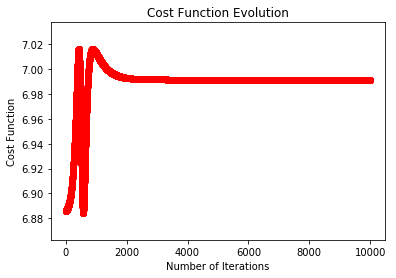

In [31]:
x = np.arange(0,len(costs),1)
plt.scatter(x,costs, c = 'r')
plt.title('Cost Function Evolution')
plt.ylabel('Cost Function')
plt.xlabel('Number of Iterations')

In [32]:
psi_up = np.dot(U_p, psi_in)

In [33]:
psi_in = states[35]
psi_up = np.dot(U_p, psi_in)

In [34]:
reference

Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[ -4.77792529e-17 -1.05277101e-19j]
 [  8.80942537e-17 +1.83797119e-16j]
 [ -2.49930333e-17 +4.90932310e-17j]
 [ -3.93979145e-02 +1.54782526e-02j]
 [ -2.87119123e-17 +2.87189513e-17j]
 [ -6.78035034e-18 -5.11226063e-17j]
 [  4.81743691e-17 +7.59067339e-17j]
 [  1.39996361e-16 -1.53833527e-16j]]

## Swap reference states with trash states

In [35]:
psi_swap = swap_trashref(psi_up, reference, opt_p)

## Construct the output
The output should ideally resemble the input.

In [36]:
psi_out = np.dot(U_p.dag(), psi_swap)

## Compare input with output

In [37]:
psi_in.norm() 

1.0

In [38]:
psi_up

Quantum object: dims = [[16], [1]], shape = (16, 1), type = ket
Qobj data =
[[  0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j]
 [  6.84363116e-01 -1.51274437e-01j]
 [  0.00000000e+00 +0.00000000e+00j]
 [ -3.44507805e-12 +0.00000000e+00j]
 [ -1.52519840e-12 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j]
 [  1.41048715e-12 +0.00000000e+00j]
 [  1.60517294e-12 +2.64820902e-12j]
 [  0.00000000e+00 +0.00000000e+00j]
 [ -7.07919487e-02 -7.09754655e-01j]
 [  0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j]]

In [39]:
psi_swap

Quantum object: dims = [[16], [1]], shape = (16, 1), type = ket
Qobj data =
[[ -4.77792529e-17 -1.05277101e-19j]
 [  8.80942537e-17 +1.83797119e-16j]
 [ -2.49930333e-17 +4.90932310e-17j]
 [ -3.93979145e-02 +1.54782526e-02j]
 [ -2.87119123e-17 +2.87189513e-17j]
 [ -6.78035034e-18 -5.11226063e-17j]
 [  4.81743691e-17 +7.59067339e-17j]
 [  1.39996361e-16 -1.53833527e-16j]
 [  0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +1.34134126e-12j]
 [  0.00000000e+00 -3.09665262e-12j]
 [  0.00000000e+00 +0.00000000e+00j]
 [  8.36755673e-02 -7.08351303e-01j]
 [  0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j]]

In [40]:
psi_out = psi_out / psi_out.norm() 

In [41]:
psi_out.norm() 

1.0000000000000002

In [42]:
ampl = psi_in.trans()*psi_out
prob = ampl.dag()*ampl
prob

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[ 0.45365692]]

In [43]:
psi_ina = psi_in.data.toarray()
psi_ina

array([[ -3.70278342e-17 -3.56216954e-17j],
       [ -2.37314403e-17 +4.74202657e-17j],
       [  2.46263574e-17 +3.31792620e-17j],
       [  2.18082873e-01 +6.66090603e-01j],
       [ -1.76068173e-16 +2.35516781e-16j],
       [  9.46891376e-13 -3.34513375e-12j],
       [  1.06615707e-12 -1.13645328e-12j],
       [ -3.09757890e-16 -4.99287486e-16j],
       [  5.27279250e-16 +9.22401268e-17j],
       [  1.06614024e-12 -1.13648547e-12j],
       [ -2.73689069e-12 -1.44879969e-12j],
       [ -8.31816527e-16 -5.99043983e-16j],
       [ -2.21939157e-01 -6.77868852e-01j],
       [ -2.30770728e-16 +2.10062480e-16j],
       [ -2.20477838e-16 +3.05258168e-17j],
       [  1.39038131e-16 -2.13765835e-20j]])

In [44]:
psi_upa = psi_up.data.toarray()
psi_upa

array([[  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  6.84363116e-01 -1.51274437e-01j],
       [  0.00000000e+00 +0.00000000e+00j],
       [ -3.44507805e-12 +0.00000000e+00j],
       [ -1.52519840e-12 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  1.41048715e-12 +0.00000000e+00j],
       [  1.60517294e-12 +2.64820902e-12j],
       [  0.00000000e+00 +0.00000000e+00j],
       [ -7.07919487e-02 -7.09754655e-01j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j]])

In [45]:
psi_swapa = psi_swap.data.toarray()
psi_swapa

array([[ -4.77792529e-17 -1.05277101e-19j],
       [  8.80942537e-17 +1.83797119e-16j],
       [ -2.49930333e-17 +4.90932310e-17j],
       [ -3.93979145e-02 +1.54782526e-02j],
       [ -2.87119123e-17 +2.87189513e-17j],
       [ -6.78035034e-18 -5.11226063e-17j],
       [  4.81743691e-17 +7.59067339e-17j],
       [  1.39996361e-16 -1.53833527e-16j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +1.34134126e-12j],
       [  0.00000000e+00 -3.09665262e-12j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  8.36755673e-02 -7.08351303e-01j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j]])

In [46]:
psi_outa = psi_out.data.toarray()
psi_outa

array([[  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [ -2.69985028e-02 -5.27308307e-02j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  1.78520541e-12 +0.00000000e+00j],
       [  2.22452796e-12 +3.71934185e-12j],
       [  0.00000000e+00 +0.00000000e+00j],
       [ -9.90746679e-02 -9.93315031e-01j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j]])

In [47]:
psi_in1 = psi_ina[8:len(psi_ina),:] 
psi_in1 = Qobj(psi_in1)

In [48]:
psi_out1 = psi_outa[8:len(psi_outa),:] 
psi_out1 = Qobj(psi_out1)

In [49]:
ampl = psi_in1.trans()*psi_out1
prob = ampl.dag()*ampl
prob

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[ 0.50697769]]

In [50]:
psi_in1

Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[  5.27279250e-16 +9.22401268e-17j]
 [  1.06614024e-12 -1.13648547e-12j]
 [ -2.73689069e-12 -1.44879969e-12j]
 [ -8.31816527e-16 -5.99043983e-16j]
 [ -2.21939157e-01 -6.77868852e-01j]
 [ -2.30770728e-16 +2.10062480e-16j]
 [ -2.20477838e-16 +3.05258168e-17j]
 [  1.39038131e-16 -2.13765835e-20j]]

In [51]:
psi_out1

Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[  0.00000000e+00 +0.00000000e+00j]
 [  1.78520541e-12 +0.00000000e+00j]
 [  2.22452796e-12 +3.71934185e-12j]
 [  0.00000000e+00 +0.00000000e+00j]
 [ -9.90746679e-02 -9.93315031e-01j]
 [  0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j]]